# Elliptical Fourier Analysis using PyEFD

Notebook to perfomr Elliptical Fourier Analysis on crystals; contouring is done using OpenCV, EF coefficients are generated using PyEFD and PCA is done using sklearn packages.
<br>
Much of the code is based on/modified for the current purposes from the publication - "Toda, Y., Okura, F., Ito, J. et al. Training instance segmentation neural network with synthetic datasets for crop seed phenotyping. Commun Biol 3, 173 (2020) https://doi.org/10.1038" 
<br>
Their code is available at the github repo - https://github.com/totti0223/crop_seed_instance_segmentation
<br>
<br>
NOTE: This is by no means a perfect notebook and it may contain errors, this is an attempt at shape analysis using EFD's which seems to work to some degree... This may be useful for later work on this topic.

In [1]:
from pyefd import elliptic_fourier_descriptors as efd
from pyefd import reconstruct_contour as recon

import numpy as np

from sklearn.decomposition import PCA
from skimage import measure, transform

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

#functions to be used in the notebook
def get_StdDev_EFD(pca, n, unit):
    """
    Function that returns the EFD's for mean and +-2STD shapes for the given PC.
    """
    
    #create list of 0's of same length as no. of features
    vector = [0] * len(pca.explained_variance_)
    #set standard deviation of specific PC to be used
    vector[n]= unit * np.sqrt(pca.explained_variance_[n])
    #get final coefficients - mean coeffs + PC*standard deviation
    final_vec = np.dot(vector, pca.components_.T) + pca.mean_
    return final_vec

def Comp2StdDev(res,n,unit):
    """
    Function to call the EFD calculator for mean and +-2STD values; coefficients are returned
    as a list of lists.
    """
    
    #EFD's for -2STD from mean
    coeff_list= get_StdDev_EFD(res, n, -1*unit)
    #EFD's for mean
    coeff_list= np.c_[coeff_list,get_StdDev_EFD(res,n,0)]
    #EFD's for +2STD from mean
    coeff_list= np.c_[coeff_list,get_StdDev_EFD(res,n,unit)]
    return coeff_list.T

def get_value(pca,xi,yi, x_pc, y_pc):
    """
    Function to calculate shapes in PCX-PCY shape in given positions.
    """
    
    #create list of 0's of same length as no. of features
    vec = [0] * len(pca.explained_variance_)
    #x and y values in desired PC space set
    vec[x_pc] = xi
    vec[y_pc] = yi
    #compute final vector
    final_vec = np.dot(vec, pca.components_.T) + pca.mean_
    return final_vec

def rotation_correct(coeffs):
    """
    Alleged rotation correction of EFD's using matrix rotation - not sure if this
    actually does the job right...
    """
    
    if coeffs[0][2] >= coeffs [0][0]:
        phi = -1*np.arctan(coeffs[0][2]/coeffs[0][0])
    elif coeffs[0][0] >= coeffs[0][2]:
        phi = -1*np.arctan(coeffs[0][0]/coeffs[0][2])
    else:
        pass
    
    if phi < (-45/180)*np.pi:
        phi += np.pi/2
    
    corrected_coeffs = np.asarray([])
    for harmonic in coeffs:        
        harm_matrix = np.asarray([[harmonic[0], harmonic[1]],
                                  [harmonic[2], harmonic[3]]])
        correction_matrix = np.asarray([[np.cos(phi), np.sin(phi)],
                                        [-np.sin(phi), np.cos(phi)]])
        corrected = np.dot(harm_matrix, correction_matrix)
        
        corrected_coeffs = np.append(corrected_coeffs,corrected.flatten())
        
    
    return corrected_coeffs


def start_point_correct(coeffs):
    """
    Another alleged correction for starting point of descriptors for the shapes, once again not sure
    if it does the job properly.
    """
    
    theta = 0.5*np.arctan((2*(coeffs[0][0]*coeffs[0][1] - coeffs[0][2]*coeffs[0][3]))/
                          (coeffs[0][0]**2 + coeffs[0][2]**2 - coeffs[0][1]**2 - coeffs[0][3]**2))
    
    if theta < (-45/180)*np.pi:
        theta += np.pi/2
    
    n = 0
    corrected_coeffs = np.asarray([])
    for harmonic in coeffs:
        n += 1
        
        harm_matrix = np.asarray([[harmonic[0], harmonic[1]],
                                  [harmonic[2], harmonic[3]]])
        correction_matrix = np.asarray([[np.cos(theta), -np.sin(theta)],
                                        [np.sin(theta), np.cos(theta)]])
        corrected = np.dot(harm_matrix, correction_matrix)
        
        corrected_coeffs = np.append(corrected_coeffs, corrected.flatten())
    
    return corrected_coeffs



Load image and generate contours for each connected region in the image.

In [455]:
img = cv2.imread("JM1_5um_FeMap_Mg discrim.png")

#convert RGB image to binary phase mask
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, phase_mask = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY)
phase_mask[phase_mask == 255] = 1

#get rid of border effect - may not be required for other images
for i in range(11):
    for j in range(len(phase_mask)):
        phase_mask[j][i] = 0
    for q in range(len(phase_mask[i])):
        phase_mask[i][q] = 0
        
for i in range(11):
    for j in range(len(phase_mask)):
        phase_mask[j][len(phase_mask[0]) - i-1] = 0
    for q in range(len(phase_mask[i])):
        phase_mask[len(phase_mask) - i-1][q] = 0

#contour shapes/crystals present
contour_list, _ = cv2.findContours(phase_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Image can be sliced up to each connected region using 'skimage.measure.regionprops' (https://scikit-image.org/docs/dev/api/skimage.measure.html) which can be rotated and contoured individually, definitely not a perfect approach but it may be a decent start?

/home/norbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2


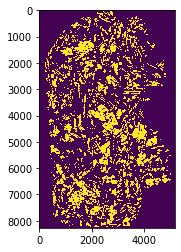

In [455]:
#THIS IS FOR ONLY IF ONE WANTS TO ROTATE EACH CRYSTAL SEPARATELY BEFORE CALCULATING EFD'S
#once again, this is not necessarily perfect - rotation may actually change image size.

#label mask and get properties
mask_label = measure.label(phase_mask, neighbors = 8)
properties = measure.regionprops(mask_label)

slices = []
rotated_contours = []
for cryst in properties:
    #to avoid erros later on
    if cryst.minor_axis_length > 0:
        
        #slice to create image of only the particular region/crystal labelled
        img = cryst.image
        #get orientation
        angle = -(cryst.orientation/np.pi)*180
        #rotate
        rot_img = transform.rotate(img, angle, resize = True)
        #create binary image again
        rot_img[rot_img < 0.5] = 0
        rot_img[rot_img >= 0.5] = 1
        
        #apply padding so crystal isn't touching edge - to result in closed contours
        new_img = np.pad(rot_img, ((1,1), (1,1)), 'constant', constant_values = ((0,0),(0,0)) )
        
        new_img = new_img.astype('uint8')
        #create contour
        new_contours, _ = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #sometimes other regions get into the image resulting in multiple contours, here we want just the longest one
        #assuming that is the crystal of interest.
        max_len = 0
        for item in new_contours:
            if len(item) > max_len:
                new_contour = item
                max_len = len(item)
            else:
                new_contour = new_contours
        
        #append both the rotated images and their contours
        slices.append(new_img)
        contours.append(new_contour)
    else:
        pass
       

# EFD and PCA

Calculate EFD's, either from original contours, for which rotation and starting point correction may be applied to, or for contours from rotated images. Then PCA is applied on the dataset calculating different scores for each PC; this information can be plotted as a scatter plot and in some studies is used to find clusters of distinct shapes and/or sizes.

/home/norbert/anaconda3/lib/python3.7/site-packages/pyefd.py:60: RuntimeWarning: invalid value encountered in true_divide
  cos_phi = (dxy[:, 0] / dt) * d_cos_phi
/home/norbert/anaconda3/lib/python3.7/site-packages/pyefd.py:62: RuntimeWarning: invalid value encountered in true_divide
  b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
/home/norbert/anaconda3/lib/python3.7/site-packages/pyefd.py:63: RuntimeWarning: invalid value encountered in true_divide
  c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
/home/norbert/anaconda3/lib/python3.7/site-packages/pyefd.py:64: RuntimeWarning: invalid value encountered in true_divide
  d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)


Text(0, 0.5, 'PC4 (1.89 %)')

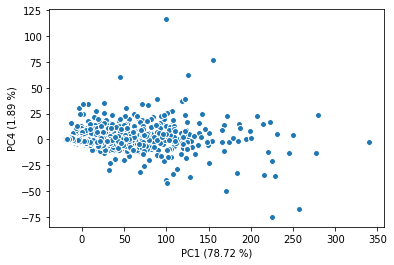

In [456]:
#create list of EFD's for each contour and store in list; also create list of contours actually used
n_harmonic = 10
features = []
used_contours = []
for item in contour_list:
    if len(item) > 1:
        try:
            features.append((efd(np.squeeze(item), order=n_harmonic, normalize=False).flatten()))
        except ValueError:
            pass
        used_contours.append(item)
    else:
        pass

#get rif of any NaN values to avoid errors
features = np.nan_to_num(features)
#perform PCA
pca = PCA()
scores = pca.fit_transform(features)

#plot PCA on PC1 and PC2
pc_x = 0
pc_y = 3

fig, ax = plt.subplots()

x = scores.T[pc_x]
y = scores.T[pc_y]

ax.scatter(x, y, edgecolors = 'white')



#add variance explained to axis labels
ax.set_xlabel("PC%s (%s %%)" %
           (str(pc_x+1), np.round(pca.explained_variance_ratio_[pc_x]*100, 2)))
ax.set_ylabel("PC%s (%s %%)" % (
    str(pc_y+1), np.round(pca.explained_variance_ratio_[pc_y]*100, 2)))

In [457]:
#fig.savefig("JM1_Olivines_PC1_PC2_scores.png", dpi = 600)

Plot to show shape variation in chosen PCX-PCY space with vaying scores in the given space.

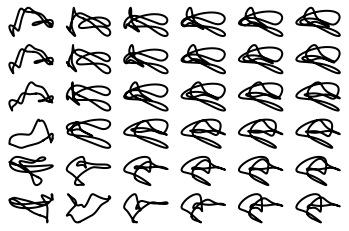

In [458]:
#set number of objects per row
n = 6
#create grid - read edge values off the PC scatter plot above
grid_y = np.linspace(-100, 250, n)
grid_x = np.linspace(-30, 350, n)

fig, ax = plt.subplots(n,n)

for i, yi in enumerate(grid_y[::-1]):
    for j, xi in enumerate(grid_x):
        #calculate EFD's and plot them on grid
        ax[i][j].axis("off")
        value = get_value(pca,xi,yi,pc_x,pc_y)
        contours = reconstruct_contour(value.reshape(n_harmonic,4))
        ax[i][j].plot(contours[:,0],contours[:,1],color="black",linewidth=2)
        ax[i][j].fill_between(contours[:,0],contours[:,1],color="white",alpha=0.5)
        

In [459]:
#fig.savefig("JM1_Olivines_PC1_PC2_ShapeVar.png", dpi = 600)

Creating plots showing how each PC contributes to different shapes.

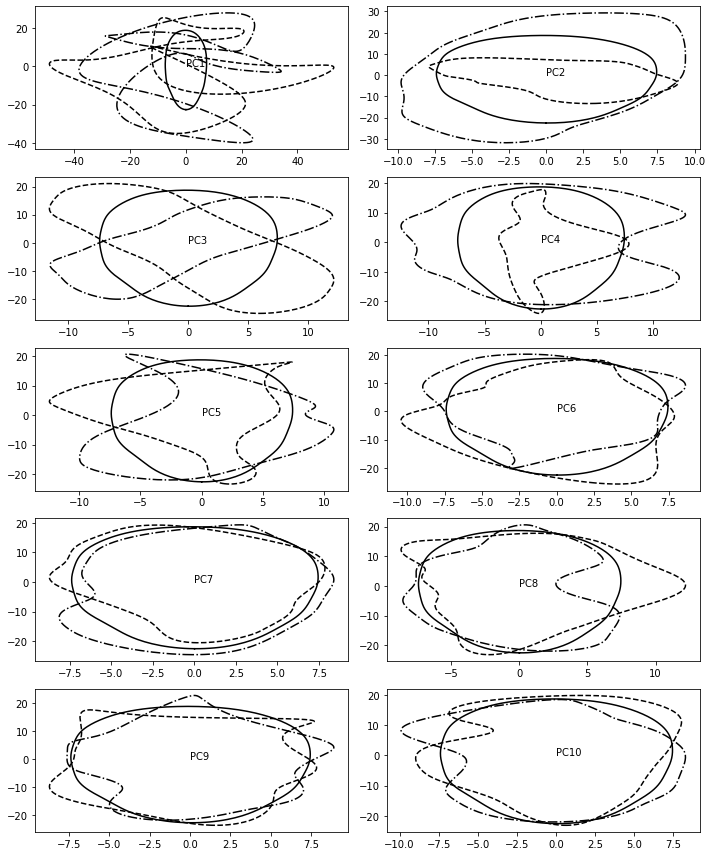

In [480]:
fig, ax = plt.subplots(5,2,figsize=(10,12))

for i in range(10):
    a = int(i/2)
    b = i%2
    
    ax[a][b].text(0,0,"PC"+str(i+1))
    #ax[a][b].axis("off")
    n = i
    unit = 1
    efms = Comp2StdDev(pca, n, unit)
    for j, style in enumerate(['--',"solid","-."]):
        contours = reconstruct_contour(efms[j].reshape(n_harmonic,4))  #pyefd function
        ax[a][b].plot(contours[:,0],contours[:,1],linestyle=style,color="black")
    
    #fig.suptitle("The first six PC's identified and their effects on average crystal shape and size")
    fig.tight_layout()

In [461]:
#fig.savefig("JM1_Olivines_FirstSixPC.png", dpi = 600)